## Installation & Libraries

In [ ]:
# !pip install --upgrade librosa

In [ ]:
import os
import librosa
import sklearn
import IPython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab import drive, auth

from PIL import Image
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

import math

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report

from tensorflow.keras import backend as K


## 1. Load Data from Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
base_path = "/content/drive/My Drive/DS 5500"

folder_path = f'{base_path}/Data/genres_original'  # replace with your folder path
files = os.listdir(folder_path)

labels = []

for file in files:
    labels.append(file)

song_dct = {}
for label in labels:
  folder_path = f'{base_path}/Data/genres_original/{label}'  # replace with your folder path
  files = os.listdir(folder_path)
  song_dct[label] = files

images_dct = {}
for label in labels:
  folder_path = f'{base_path}/Data/images_original/{label}'  # replace with your folder path
  files = os.listdir(folder_path)
  images_dct[label] = files




## 2. Data Preprocessing

### Convert to Spectrograms (full audio processing)

In [ ]:
# # Prepare empty dictionaries to store the Mel spectrograms and rejected files
# mel_spectrograms = {}
# rejected_files = {}

# for label, files in song_dct.items():
#     mel_spectrograms[label] = []  # Initialize empty list for this label
#     for file in files:
#         # Construct full file path
#         file_path = f'/content/drive/My Drive/DS 5500/Data/genres_original/{label}/{file}'

#         try:
#             # Load audio file
#             y, sr = librosa.load(file_path)
#             y, _ = librosa.effects.trim(y)

#             # Compute Mel spectrogram
#             mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

#             # Convert to log scale
#             log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

#             # Append log Mel spectrogram to list for this label
#             mel_spectrograms[label].append(log_mel_spectrogram)
#         except Exception as e:
#             print(f"Could not process file {file_path}: {e}")
#             if label in rejected_files:
#                 rejected_files[label].append(file_path)
#             else:
#                 rejected_files[label] = [file_path]

# print(f"Processed files. {len(rejected_files)} files were rejected.")

### Convert to Spectrograms (clipped audio processing)

In [ ]:
clip_duration = 3  # Duration of each clip in seconds

# Prepare empty dictionaries to store the Mel spectrograms and rejected files
mel_spectrograms = {}
rejected_files = {}

for label, files in song_dct.items():
    mel_spectrograms[label] = []  # Initialize empty list for this label
    for file in files:
        # Construct full file path
        file_path = f'/content/drive/My Drive/DS 5500/Data/genres_original/{label}/{file}'

        try:
            # Load audio file
            y, sr = librosa.load(file_path)
            y, _ = librosa.effects.trim(y)

            # Calculate the number of samples in each clip
            clip_samples = int(sr * clip_duration)

            # Calculate the number of clips
            num_clips = math.ceil(len(y) / clip_samples)

            # Split the audio into clips
            for i in range(num_clips):
                start_sample = i * clip_samples
                end_sample = start_sample + clip_samples

                # Check if the end sample exceeds the length of the audio
                if end_sample > len(y):
                    clip = np.pad(
                        y[start_sample:], (0, end_sample - len(y)), mode='constant'
                    )
                else:
                    clip = y[start_sample:end_sample]

                # Compute Mel spectrogram for the clip
                mel_spectrogram = librosa.feature.melspectrogram(y=clip, sr=sr)

                # Convert to log scale
                log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

                # Append log Mel spectrogram to list for this label
                mel_spectrograms[label].append(log_mel_spectrogram)
        except Exception as e:
            print(f"Could not process file {file_path}: {e}")
            if label in rejected_files:
                rejected_files[label].append(file_path)
            else:
                rejected_files[label] = [file_path]

print(f"Processed files. {len(rejected_files)} files were rejected.")


<ipython-input-6-246053cf28c6>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not process file /content/drive/My Drive/DS 5500/Data/genres_original/jazz/jazz.00054.wav: 
Processed files. 1 files were rejected.


### Mel Spectrogram Resizing

In [ ]:
# Define target image dimensions
image_width = 64
image_height = 64
num_channels = 3

# Prepare empty dictionary to store converted spectrograms
converted_spectrograms = {}

# Convert spectrograms to image-like format
for label, spectrograms in mel_spectrograms.items():
    converted_spectrograms[label] = []  # Initialize empty list for this label
    for spectrogram in spectrograms:
        # Normalize the spectrogram to [0, 1]
        spectrogram_normalized = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))

        # Convert the spectrogram array to uint8 data type
        spectrogram_uint8 = (spectrogram_normalized * 255).astype(np.uint8)

        # Create a PIL image from the spectrogram array
        spectrogram_image = Image.fromarray(spectrogram_uint8)

        # Convert the grayscale image to RGB
        spectrogram_image_rgb = spectrogram_image.convert('RGB')

        # Resize the image
        image = spectrogram_image_rgb.resize((image_width, image_height))

        # Convert the image to a NumPy array
        image_array = np.array(image)

        # Normalize the pixel values to [0, 1]
        image_array_normalized = image_array / 255.0

        # Convert the array to a TensorFlow tensor
        tensor_image = tf.convert_to_tensor(image_array_normalized, dtype=tf.float32)

        # Append the converted tensor to the list for the current label
        converted_spectrograms[label].append(tensor_image)

<ipython-input-7-ead220d4de67>:14: RuntimeWarning: invalid value encountered in true_divide
  spectrogram_normalized = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))


### Assign X, Y variables

In [ ]:
# Prepare empty lists to store the spectrograms and labels
X = []
y = []

# Iterate over the mel spectrograms
for label, spectrograms in converted_spectrograms.items():
  if label != 'reggae':
    for spectrogram in spectrograms:
        X.append(spectrogram)
        y.append(label)

# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Perform label encoding
label_encoder = LabelEncoder()
y_label_encoded = label_encoder.fit_transform(y)

# Perform one-hot encoding
y_one_hot = to_categorical(y_label_encoded)

In [ ]:
X.shape


(9878, 64, 64, 3)

In [ ]:
y_one_hot.shape

(9878, 9)

# Build and Train Model

In [ ]:
# Define number of classes
num_classes = 9

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2)

# Create the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Define learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # callback to stop training if validation loss doesn't improve in 10 epochs

# Train the model
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
history

Epoch 1/60
247/247 [==============================] - 13s 10ms/step - loss: 1.8658 - accuracy: 0.2875 - val_loss: 1.5042 - val_accuracy: 0.4686
Epoch 2/60
247/247 [==============================] - 2s 7ms/step - loss: 1.3413 - accuracy: 0.4982 - val_loss: 1.2760 - val_accuracy: 0.5461
Epoch 3/60
247/247 [==============================] - 2s 7ms/step - loss: 1.1863 - accuracy: 0.5671 - val_loss: 1.1699 - val_accuracy: 0.5774
Epoch 4/60
247/247 [==============================] - 2s 8ms/step - loss: 1.0687 - accuracy: 0.6025 - val_loss: 1.0692 - val_accuracy: 0.5977
Epoch 5/60
247/247 [==============================] - 2s 8ms/step - loss: 0.9845 - accuracy: 0.6409 - val_loss: 1.0265 - val_accuracy: 0.6230
Epoch 6/60
247/247 [==============================] - 2s 9ms/step - loss: 0.8921 - accuracy: 0.6711 - val_loss: 1.1794 - val_accuracy: 0.5754
Epoch 7/60
247/247 [==============================] - 2s 8ms/step - loss: 0.8166 - accuracy: 0.6997 - val_loss: 0.9421 - val_accuracy: 0.6544
Epoc

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

# Plot Accuracy and Loss

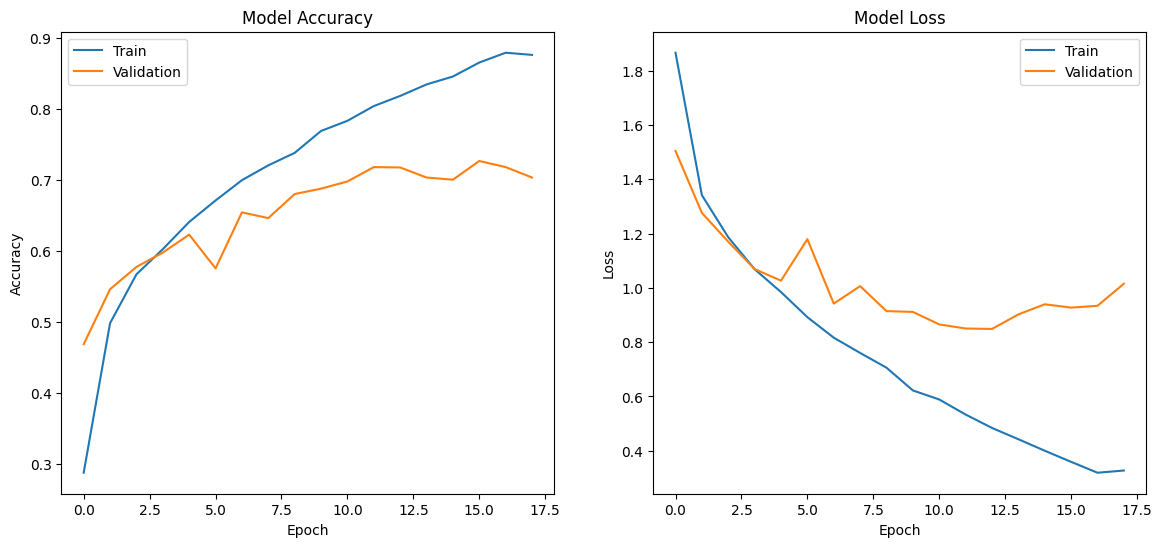

In [ ]:
# Plotting accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.show()

In [ ]:
K.clear_session()

# Plot Confusion Matrix

62/62 [==============================] - 0s 2ms/step


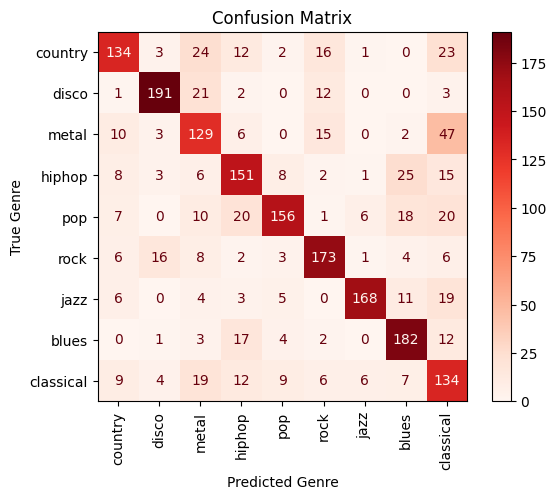

In [ ]:
# Assuming you have the model and the validation data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels[:-1])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')

# Rotate xticks vertically
plt.xticks(rotation='vertical')
plt.show()

# Classification Report

In [ ]:
# Make predictions on the validation set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=labels[:-1], zero_division=0)

# Print the classification report
print(report)

62/62 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

     country       0.74      0.62      0.68       215
       disco       0.86      0.83      0.85       230
       metal       0.58      0.61      0.59       212
      hiphop       0.67      0.69      0.68       219
         pop       0.83      0.66      0.73       238
        rock       0.76      0.79      0.78       219
        jazz       0.92      0.78      0.84       216
       blues       0.73      0.82      0.77       221
   classical       0.48      0.65      0.55       206

    accuracy                           0.72      1976
   macro avg       0.73      0.72      0.72      1976
weighted avg       0.73      0.72      0.72      1976



In [ ]:
# !jupyter nbconvert --to html /content/Copy_of_DS5500_Capstone_Project_Music_Genre_Classification.ipynb